In [ ]:
import pickle

# Specify the path to your pickle file
# file_path = 'symptom_embeddings_dict_mbxai.pkl'
file_path = 'cluster_embed_mxbai_jun17.pkl'


# Load the pickle file
with open(file_path, 'rb') as file:
    data = pickle.load(file)

# Use the loaded data
print("Loaded Data:", data)


In [ ]:
!ollama pull mxbai-embed-large

In [ ]:
del_list = ['see also', 'SIBS', 'sibling','death','die','families','family','prevalence','deletion','mutation','increased frequency', 'translocation','reported','report','clinical information', 'incidence 1 in', 'births', 'allelic', 'four major groups', 'consanguineous','x-inactivation','patient b','30% of cases','two types']

In [ ]:
rep_list = ['some patients show', 'patients may present with', 'increased incidence in individuals','may occur', 'some patients']

In [ ]:
m = {}
import ollama
sym_new = {}
for d in data.keys():
    if not d.lower().startswith('caused by'):
        x = 'no'
        for del_word in del_list:
            if del_word in d.lower():
                x = 'yes'
                break
        if x == 'yes':
            continue
        s = d.lower()
        for k in rep_list:
            s = s.replace(k, '')
        if len(s.strip()) <= 3:
            continue
        m[s] = ollama.embeddings(prompt=s,model="mxbai-embed-large")['embedding']
        sym_new[d] = s
    else:
        sym_new[d] = 'del'

In [ ]:
with open('sym_map.pkl', 'wb') as f:
    pickle.dump(sym_new, f)

In [ ]:
with open('cluster_embed_mxbai_jun17.pkl', 'wb') as f:
    pickle.dump(m, f)

In [1]:
import pickle
with open('cluster_embed_mxbai_jun17.pkl', 'rb') as f:
    loaded_dict = pickle.load(f)

In [9]:
len(loaded_dict.keys())


14519

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
embeddings = loaded_dict

def hierarchical_clustering_to_file(
    embeddings,
    metric='cosine',
    method='average',
    n_clusters=None,
    distance_threshold=None,
    output_file="clusters.csv"
):
    words = list(embeddings.keys())
    X = np.vstack(list(embeddings.values()))

    if method == "ward" and metric != "euclidean":
        print("[INFO] Ward linkage only supports Euclidean distance. Switching to metric='euclidean'.")
        metric = "euclidean"

    # Perform hierarchical clustering
    Z = linkage(X, method=method, metric=metric)

    # Determine cluster assignments
    if n_clusters:
        clusters = fcluster(Z, t=n_clusters, criterion="maxclust")
    elif distance_threshold:
        clusters = fcluster(Z, t=distance_threshold, criterion="distance")
    else:
        clusters = fcluster(Z, t=1.0, criterion="inconsistent")  # default

    # Create a dataframe for output
    df = pd.DataFrame({"word": words, "cluster": clusters})

    # Save to file
    df.to_csv(output_file, index=False)
    print(f"[INFO] Saved {len(df)} words with cluster assignments to {output_file}")

    # Optional: plot dendrogram
    plt.figure(figsize=(10, 5))
    dendrogram(Z, labels=words, leaf_rotation=90, leaf_font_size=10, color_threshold=None)
    plt.title(f'Hierarchical Clustering Dendrogram ({method}, {metric})')
    plt.tight_layout()
    plt.show()

    return df


[INFO] Saved 14519 words with cluster assignments to my_clusters.csv


/var/folders/dx/w12_nqjs5hn8d_fp7g1q4z100000gn/T/ipykernel_7246/3760128806.py:44: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


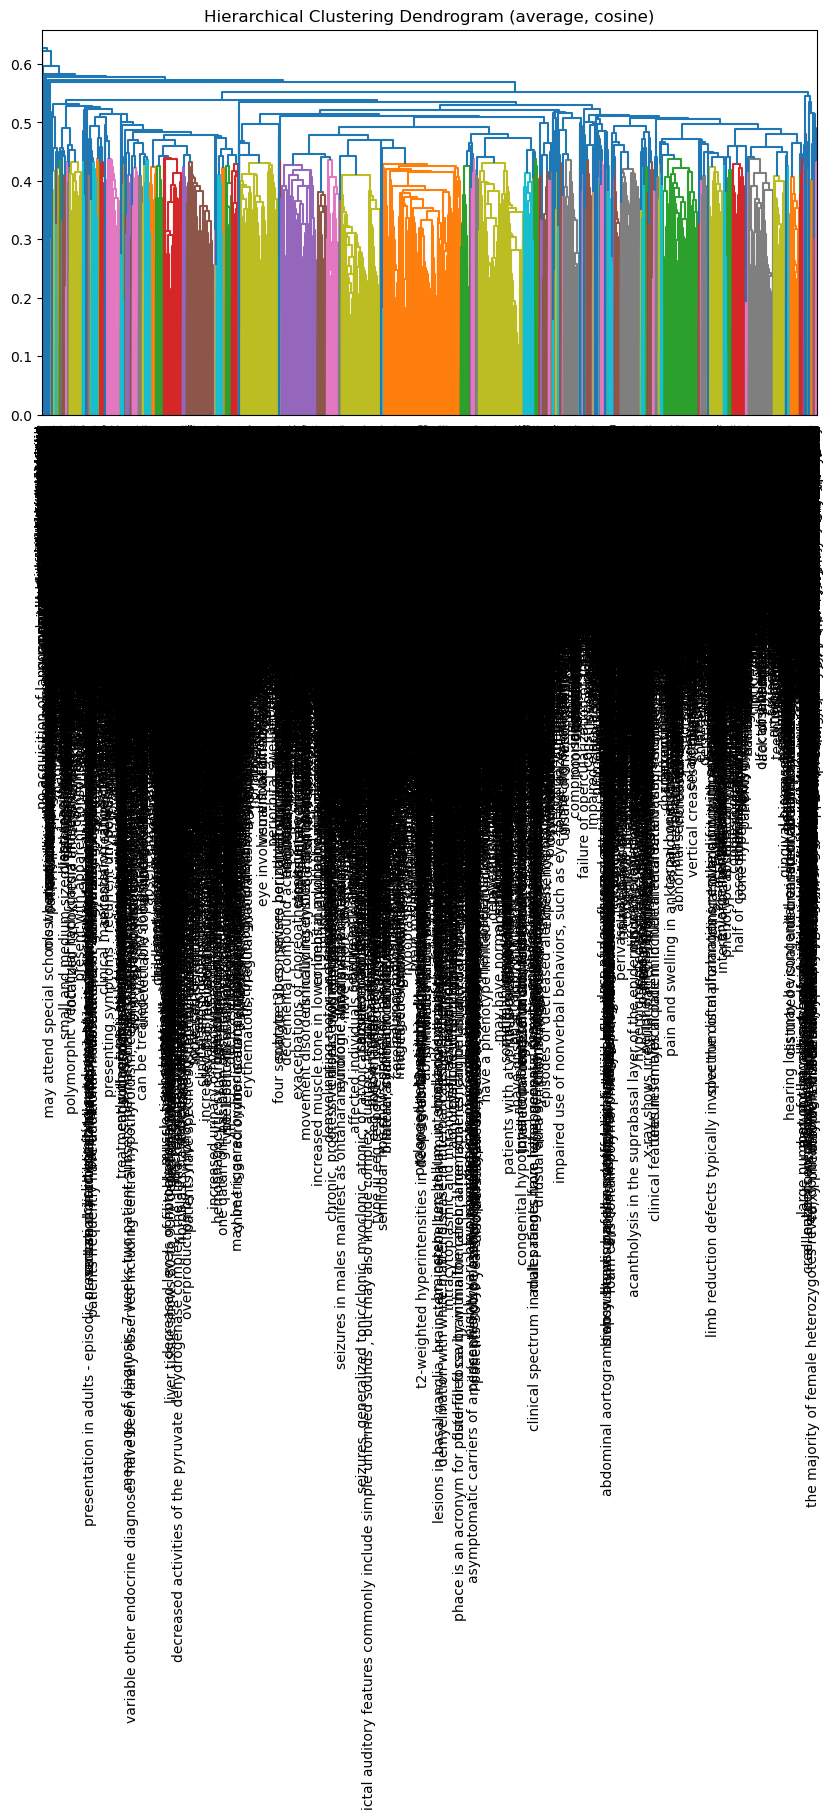

In [30]:
# Example call with fixed number of clusters
df_clusters = hierarchical_clustering_to_file(
    embeddings,
    metric='cosine',
    method='average',
    n_clusters=5,
    output_file="my_clusters.csv"
)

In [22]:
# Extract terms and vectors
from sklearn.cluster import KMeans
term_vector_dict = loaded_dict
terms = list(term_vector_dict.keys())
vectors = list(term_vector_dict.values())

# Number of clusters (adjust as needed)
n_clusters = 8000

# Perform K-Means clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(vectors)
labels = kmeans.labels_

# Organize terms by cluster
clusters = {i: [] for i in range(n_clusters)}
for term, label in zip(terms, labels):
    clusters[label].append(term)

In [24]:
print(len(clusters))

8000


In [23]:
# Write clustered terms to a file
output_file = 'clustered_terms_8000_mxbai_cleaned_sep16.txt'
with open(output_file, 'w') as f:
    for cluster_id, cluster_terms in clusters.items():
        f.write(f"Cluster {cluster_id}:\n")
        for term in cluster_terms:
            f.write(f"  {term}\n")
        f.write("\n")

print(f"Clusters written to {output_file}")

Clusters written to clustered_terms_8000_mxbai_cleaned_sep16.txt


In [ ]:
print(clusters[588])

In [ ]:
' are asymptomatic and detected only by newborn screening' in loaded_dict.keys()